Advanced Machine Learning, Fall 2020  
Author: Rahul Bhatia (rb3318)  
Due Wednesday, 10/23/20

In [167]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
from sklearn.cluster import DBSCAN, MeanShift, estimate_bandwidth
from sklearn.neighbors import KNeighborsClassifier

# Problem 1

## Part A: Derive expressions for $\nabla F$ and $\nabla^2 F$

$$ \nabla F = Ax - b $$  
$$ \nabla^2 F = A $$

## Part B: What is the minimizer of F

$$ x^* = \underset{x}{\operatorname{argmin}} F(x) $$  
$$ \nabla F = Ax - b \Rightarrow 0 $$  
$$ Ax^* = b $$
Since $A \succ 0$
$$ x^* = A^{-1} b $$  

## Part B Show that Newton's minimizes F in one step

$$ x_2 = x_1 - \eta (\nabla^2 F(x_1))^{-1} \nabla F(x_1) $$  
Since $\eta = 1$  
$$ x_2 = x_1 - A^{-1} (Ax_1 - b) $$  
$$ x_2 = x_1 - x_1 + A^{-1} b $$  
$$ x_2 = A^{-1} b $$  
$$ x_2 = x^* $$  

# Problem 2

Recall Gradient Descent Step: 
$$ x_{t+1} = x_t - \eta \nabla{F(x)} $$
Now starting with Newton's Method, we have the following step:  
$$ x_{t+1} = x_t - \eta_{NM} (\nabla^2 F(x))^{-1} \nabla F(x) $$  
$$ \nabla^2 F(x) = c I_d $$  
$$ \nabla^2 F(x)^{-1} = \dfrac{1}{c} I_d $$   
$$ x_{t+1} = x_t - \eta_{NM} \dfrac{1}{c} \nabla F(x) $$  
Therefore, the Newton's method reduces to the gradient step where:
$$ \eta = \dfrac{1}{c} \eta_{NM} $$

# Problem 3

In [60]:
def create_datasets(seed):
    random.seed(seed)
    
    ##Data set 1
    X1 = []
    for i in range(1000):
        theta = random.uniform(0,2*math.pi)
        radius = random.gauss(0,0.2)+random.choice([1,3])
        X1.append([radius*math.cos(theta),radius*math.sin(theta)])
    X1 = np.array(X1)
    ##Data Set 2
    X2 = []
    for i in range(1000):
        theta = random.uniform(0,2*math.pi)
        radius = random.gauss(0,0.1) + 2
        if theta<math.pi:
            X2.append([radius*math.cos(theta)-1,radius*math.sin(theta)])
        else:
            X2.append([radius*math.cos(theta)+1,radius*math.sin(theta)])
    X2 = np.array(X2)
    ##Data Set 3
    X3 = []
    for i in range(1000):
        radius = random.gauss(0,1)
        theta = random.uniform(0,2*math.pi)
        center = random.choice([[0,1],[3,3],[1,-3]])
        X3.append([radius*math.cos(theta)+center[0],radius*math.sin(theta)+center[1]])
    X3 = np.array(X3)
    return X1, X2, X3


def plot_clusters(X, label_pred=None, ax=None):
    mark = ['or', 'ob', 'oy', 'g', 'c', 'm', 'k']
    j = 0
    if label_pred is None:
        label_pred = np.zeros(X.shape[0]).astype('int')
    for i in label_pred:
        if ax is not None:
            ax.plot([X[j:j+1,0]], [X[j:j+1,1]], mark[i], markersize = 5)
        else:
            plt.plot([X[j:j+1,0]], [X[j:j+1,1]], mark[i], markersize = 5)
        j +=1 

In [12]:
X = create_datasets(0)

## Part A: Results using DBSCAN

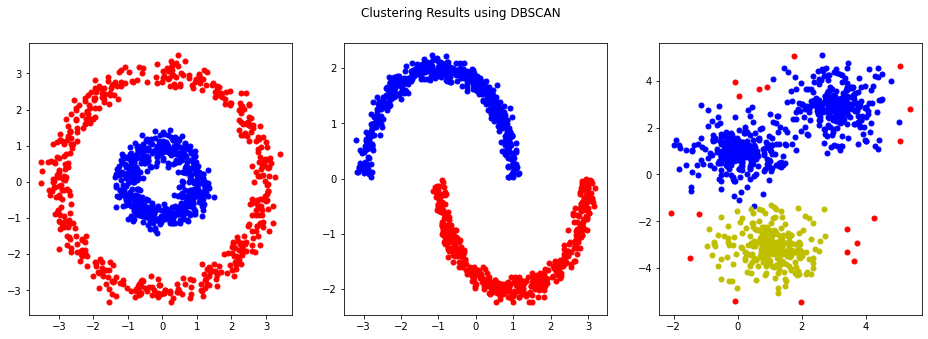

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Clustering Results using DBSCAN")
min_samples = 400

X0_label = (DBSCAN(eps=estimate_bandwidth(X[0], quantile=0.2),
                   min_samples=400)
            .fit(X[0]).labels_)
X1_label = (DBSCAN(eps=estimate_bandwidth(X[1], quantile=0.2),
                   min_samples=100)
            .fit(X[1]).labels_)
X2_label = (DBSCAN(eps=estimate_bandwidth(X[2], quantile=0.2),
                   min_samples=100)
            .fit(X[2]).labels_)

plot_clusters(X=X[0], label_pred=(1 + X0_label), ax=ax[0])
plot_clusters(X=X[1], label_pred=(X1_label), ax=ax[1])
plot_clusters(X=X[2], label_pred=(1 + X2_label), ax=ax[2])

## Part B: Results using MeanShift

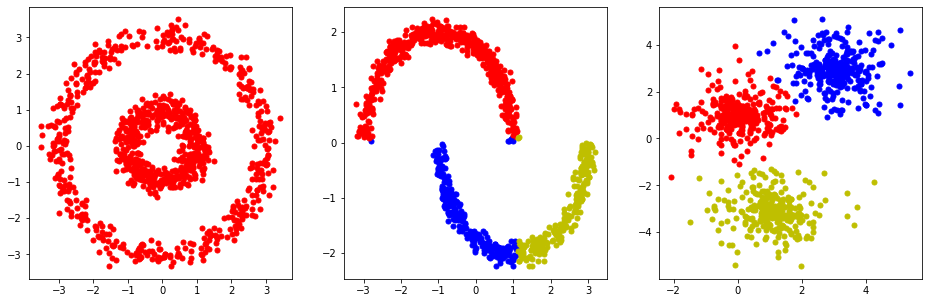

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

plot_clusters(X[0],
              MeanShift(bandwidth=estimate_bandwidth(X[0],quantile=0.2)).fit(X[0]).labels_,
              ax=ax[0])
plot_clusters(X[1],
              MeanShift(bandwidth=estimate_bandwidth(X[1], quantile=0.2)).fit(X[1]).labels_,
              ax=ax[1])
plot_clusters(X[2],
              MeanShift(bandwidth=estimate_bandwidth(X[2], quantile=0.2)).fit(X[2]).labels_,
              ax=ax[2])

## Part C: Comparing DBSCAN to MeanShift

On the first two datasets, DBSCAN vastly outperforms MeanShift on the first two datasets due to the nature of the algorithm. In dataset 1, MeanShift underperforms because it's a centroid based algorithm, and the center of the two clusters is identical. On the other hand, DBSCAN starts with arbitrary points and uses the interpoint distances to group points near it into clusters, recursively. This means it can discover the clusters in dataset 1 due to the drop in density in between the clusters. This iterative approach is also the reason that DBSCAN prevails in dataset 2; the algorithm is discovering points by iterating through the data, grouping points that are near enough to each other by some measure of density. This solves the second dataset since we have two clusters that are highly dense but separated by space.

# Problem 4: Compare Adam vs Adagrad

## Part A: Compare Adam vs Adagrad

In [91]:
def autograd(X, y, penalty, beta):
    """Autograd"""
    d = 10
    n = len(y)
    W_t = np.zeros((n + 1, d, 1))
    nabla_F_t = np.zeros((n + 1, d, 1))
    sigma_t_i_2 = np.zeros((n + 1, d, 1))
    eta_t_i = np.zeros((n + 1, d, 1))
    for t in range(0, n):
        X_i = np.reshape(X[t], (d, 1))
        nabla_a = -2 * (y[t] - np.matmul(W_t[t].T, X_i)) * X_i
        nabla_b = 2 * penalty * W_t[t]
        nabla_F_t[t] = (1 / n) * (nabla_a + nabla_b)
        sigma_t_i_2[t] = np.array([
            [np.sum([nabla_F[i]**2 for nabla_F in nabla_F_t])]
            for i in np.arange(d)])
        eta_t_i[t] = np.sqrt(1 / (beta * sigma_t_i_2[t]))
        W_t[t + 1] = W_t[t] - np.matmul(np.diag(eta_t_i[t].reshape(10)), nabla_F_t[t])
    return W_t

In [139]:
def mu_s(s, t):
    """mu_s"""
    t_1 = t + 1  # t is 1 indexed in this calculation
    return 1.1 ** (s - t_1) * (t_1 / (11 * (1 - 1.1 ** -t_1)))


def adam(X, y, penalty, beta):
    """ADAM"""
    d = 10
    n = len(y)
    W_t = np.zeros((n + 1, d, 1))
    nabla_F_t = np.zeros((n + 1, d, 1))
    sigma_t_i_2 = np.zeros((n + 1, d, 1))
    eta_t_i = np.zeros((n + 1, d, 1))
    for t in range(0, n):
        X_i = np.reshape(X[t], (d, 1))
        nabla_a = -2 * (y[t] - np.matmul(W_t[t].T, X_i)) * X_i
        nabla_b = 2 * penalty * W_t[t]
        nabla_F_t[t] = (1 / n) * (nabla_a + nabla_b)
        sigma_t_i_2[t] = np.array([
            [np.sum([mu_s(s, t) * nabla_F[i] ** 2 for s, nabla_F in enumerate(nabla_F_t)])]
            for i in np.arange(d)])
        eta_t_i[t] = np.sqrt(1 / (beta * sigma_t_i_2[t]))
        W_t[t + 1] = W_t[t] - np.matmul(np.diag(eta_t_i[t].reshape(10)), nabla_F_t[t])
    return W_t

In [102]:
## Code for generator / sampler
sigma = 1
d = 10
c_square = 100
cov = np.diag([(0.25 ** i) * c_square for i in range(1, d + 1)])
mean = [0] * d
w = np.array([1] * d)


def sampler(n):
    np.random.seed(int(time.time() * 100000) % 100000)
    X = np.array(np.random.multivariate_normal(mean, cov, n))
    Y = np.matmul(X, w) + np.random.normal(0, sigma ** 2, n)
    return (X, Y)

In [100]:
samples = []
for iteration in range(10):
    print(f"iteration {iteration}")
    penalty = 0.1
    X, y = sampler(1000)
    W_t_adam = adam(X, y, penalty=penalty, beta=2 * (cov[0][0] + penalty))
    W_t_adam_series = pd.Series([np.linalg.norm(W_t, 2)
                                 for W_t in W_t_adam - np.ones(W_t_adam.shape)])
    samples.append(W_t_adam_series
                   .rename("dist")
                   .reset_index()
                   .rename(columns=dict(index='t'))
                   .assign(iteration=iteration, optimizer='adam'))
    W_t_autograd = autograd(X, y, penalty=penalty, beta=2 * (cov[0][0] + penalty))
    W_t_autograd_series = pd.Series(
        [np.linalg.norm(W_t, 2)
         for W_t in W_t_autograd - np.ones(W_t_autograd.shape)])
    samples.append(W_t_autograd_series
                   .rename("dist")
                   .reset_index()
                   .rename(columns=dict(index='t'))
                   .assign(iteration=iteration, optimizer='autograd'))

all_samples = pd.concat(samples)

iteration 0
iteration 1
iteration 2
iteration 3


Exception ignored in: <function tqdm.__del__ at 0x7fe3195be200>
Traceback (most recent call last):
  File "/Users/rahul/opt/miniconda3/envs/aml/lib/python3.7/site-packages/tqdm/std.py", line 1122, in __del__
    self.close()
  File "/Users/rahul/opt/miniconda3/envs/aml/lib/python3.7/site-packages/tqdm/notebook.py", line 261, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


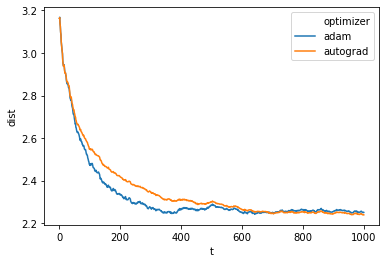

In [105]:
ax = sns.lineplot(x='t', y='dist', hue='optimizer', ci=None, estimator='mean', data=all_samples)

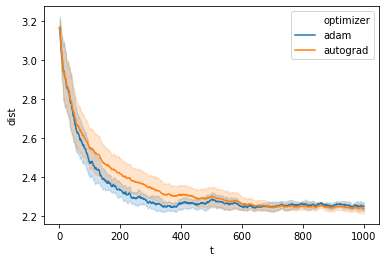

In [106]:
ax = sns.lineplot(x='t', y='dist', hue='optimizer', data=all_samples)

## Part B

The estimation Adam makes on $\sigma_{i,t}^2$ may be better than that of Adagrad because it uses an exponentially decaying weight for each historical estimate of nabla. In Adagrad, this estimate of the second moment has the effect of reducing the learning rate when the gradient is large.  Adam takes this one step further by decreasing the relative contribution of each new estimate of the gradient, as we iterate through the dataset. This effect of this drops the learning rate further when newer estimates of the gradient are large. This stabilizes our search by preventing our algorithm from being swayed by newer gradients.

Text(0.5, 1.0, 'mu_s as a function of s, for samples of t')

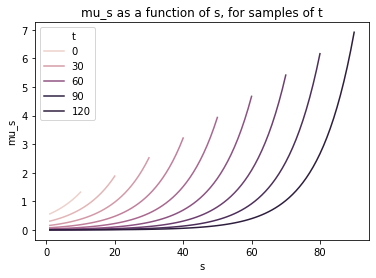

In [147]:
fig, ax = plt.subplots(1, 1)
mu_s_df = pd.DataFrame([{"s": s, "t": t, "mu_s": mu_s(s, t)} for t in range(1, 100) for s in range(1, t)])
sns.lineplot(x='s', y='mu_s', hue='t', data=mu_s_df.loc[mu_s_df.t.isin([t for t in range(1, 100, 10)])], ax=ax)
ax.set_title("mu_s as a function of s, for samples of t")

# Problem 5: Bias and Variance

## Part A: For the largest possible choice of k = n, the model fk is constant. Why?

If K is set to n, the sample size, then the model output will be constant for each data point. This is because, for each point, the algorithm will consider all other data points and choose the class that comprises the majority of the full dataset. Since we consider the whole dataset everu time when we classify a point, we are always going to choose the same class. Therefore, whatever the majority class is in the dataset, that will be the class assigned to every point. In the case of this data generating model, we will find that every point will be classified as the 1st class, since that class comprises roughly 50% of the overall dataset.


## Part B

In [148]:
d = 2
mu0 = [[-2, -3.5], [0, 0], [2, -3.5]]
id = [[25, 0], [0, 25]]


def data_generate(n):
    outX = []
    outY = np.random.choice(list(range(3)), n, replace=True, p=[0.5, 0.25, 0.25])
    for i in range(n):
        mu = mu0[outY[i]]
        X = np.random.multivariate_normal(mu, id, 1)[0].tolist()
        outX.append(X)
    return outX, outY

In [169]:
n = 500
test_x, test_y = data_generate(n)


In [170]:
def test_error(test_x, test_y, classifier):
    """Compute the Test Error of a Given Classifier"""
    return np.mean(classifier.predict(test_x) != test_y)

In [171]:
results = []
for i in range(10):
    train_X, train_Y = data_generate(n)
    for k in range(1, 500, 50):
        model_spec = KNeighborsClassifier(n_neighbors=k)
        model = model_spec.fit(train_X, train_Y)
        error = test_error(test_x, test_y, model)
        results.append({"train": i, "k": k, "error": error})
results_df = pd.DataFrame(results)

Text(0.5, 1.0, "$\\hat{R}_n' (\\hat{f}_k)$ ")

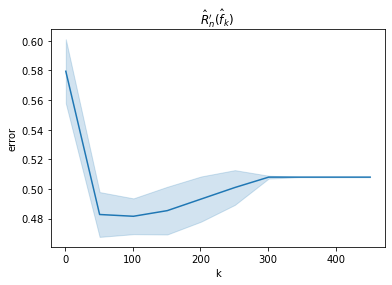

In [189]:
fig, ax = plt.subplots()
sns.lineplot(x='k', y='error', ci='sd', data=results_df, ax=ax)
ax.set_title("$\hat{R}_n' (\hat{f}_k)$ ")

## Part C

We observe more variance in smaller values of k because classifiers with a small value of k can fit more complex functions over the space of the input. As a result of this increased flexibility, the model's that we fit will be more closely fit to the training data, which weakens the model's generalizability. This weakness is exhibited in the variance of the model's test error on our hold out sample.

# Problem 6: Model Selection

## Part A

The answer is (iii), we don't know until we assess $R_n(\hat{f_k})$, the true risk. We might use $\hat{R}_n'(\hat{f_k})$, the test risk, as an estimate of the true risk. 

## Part B
(ii) is correct, so if n is sufficiently large, then under some conditions on l, $R_n'(f)$ is a good estimate of $R(f)$ for any fixed f.

Unless we believe our test data is large and representative of the population distribution, we cannot claim that our empirical risk on the test data is a good estimate of the true risk. This is where one might employ more complex validation techniques, such as k-fold validation.

## Part C

(iii) We should pick a larger class $\mathcal{F}_j, \; j > k$.